In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')


In [ ]:
!pip install finance-datareader
import FinanceDataReader as fdr

In [ ]:
samsung = fdr.DataReader('005930', '2015')
samsung.head(10000)

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2015-01-02,26799,26799,26540,26600,175499,0.002261
2015-01-05,26720,26720,26260,26660,202790,0.002256
2015-01-06,26300,26340,25760,25900,304710,-0.028507
2015-01-07,25880,26220,25640,26140,286455,0.009266
2015-01-08,26780,26780,26199,26280,289552,0.005356
...,...,...,...,...,...,...
2023-04-27,64100,65000,63300,64600,14779601,0.007800
2023-04-28,65200,65900,65000,65500,19699481,0.013932
2023-05-02,66000,66300,65100,65700,14396948,0.003053


In [ ]:
samsung.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2023-04-27,64100,65000,63300,64600,14779601,0.007800
2023-04-28,65200,65900,65000,65500,19699481,0.013932
2023-05-02,66000,66300,65100,65700,14396948,0.003053
2023-05-03,65100,65600,64900,65400,8876749,-0.004566
2023-05-04,65600,65700,64700,65100,9763209,-0.004587


In [ ]:
samsung.index

DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-15',
               ...
               '2023-04-20', '2023-04-21', '2023-04-24', '2023-04-25',
               '2023-04-26', '2023-04-27', '2023-04-28', '2023-05-02',
               '2023-05-03', '2023-05-04'],
              dtype='datetime64[ns]', name='Date', length=2054, freq=None)

In [ ]:
samsung['Year'] = samsung.index.year
samsung['Month'] = samsung.index.month
samsung['Day'] = samsung.index.day

In [ ]:
samsung.head()

,Open,High,Low,Close,Volume,Change,Year,Month,Day
Date,,,,,,,,,
2015-01-02,26799,26799,26540,26600,175499,0.002261,2015,1,2
2015-01-05,26720,26720,26260,26660,202790,0.002256,2015,1,5
2015-01-06,26300,26340,25760,25900,304710,-0.028507,2015,1,6
2015-01-07,25880,26220,25640,26140,286455,0.009266,2015,1,7
2015-01-08,26780,26780,26199,26280,289552,0.005356,2015,1,8


Text(0, 0.5, 'price')

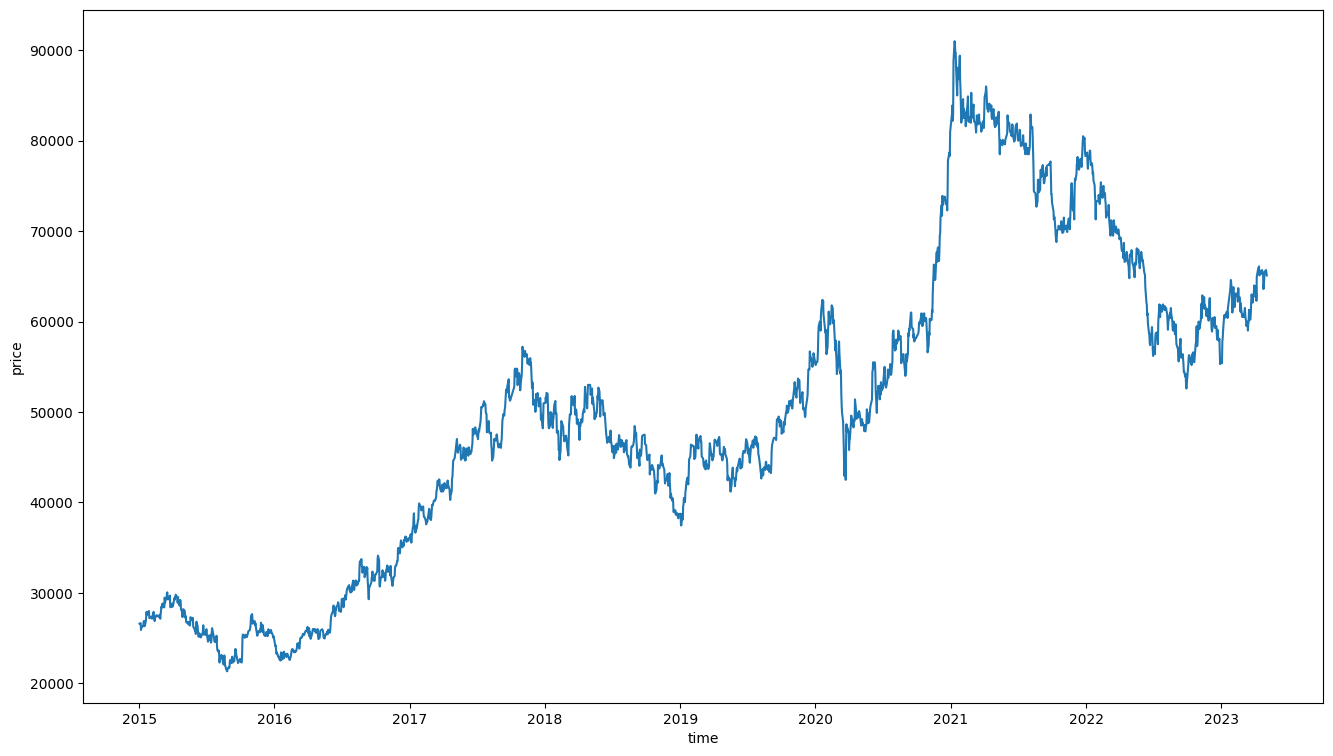

In [ ]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=samsung['Close'], x=samsung.index)
plt.xlabel('time')
plt.ylabel('price')

### 데이터 전처리

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(samsung[scale_cols])
scaled

array([[0.29677741, 0.27684917, 0.29653631, 0.07550962, 0.00194338],
       [0.29590255, 0.27603306, 0.29340782, 0.07637094, 0.00224558],
       [0.29125138, 0.27210744, 0.28782123, 0.06546081, 0.00337419],
       ...,
       [0.73089701, 0.68491736, 0.7273743 , 0.63680735, 0.15942373],
       [0.72093023, 0.67768595, 0.72513966, 0.63250072, 0.09829614],
       [0.72646733, 0.67871901, 0.72290503, 0.62819409, 0.10811231]])

In [ ]:
df = pd.DataFrame(scaled, columns=scale_cols)

### Train / Test 분할

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [ ]:
x_train.shape, y_train.shape

((1643, 4), (1643,))

In [ ]:
x_test.shape, y_test.shape

((411, 4), (411,))

In [ ]:
x_train

,Open,High,Low,Volume
0,0.296777,0.276849,0.296536,0.001943
1,0.295903,0.276033,0.293408,0.002246
2,0.291251,0.272107,0.287821,0.003374
3,0.286600,0.270868,0.286480,0.003172
4,0.296567,0.276653,0.292726,0.003206
...,...,...,...,...
1638,0.822813,0.774793,0.824581,0.168015
1639,0.834994,0.779959,0.829050,0.140489
1640,0.829457,0.792355,0.830168,0.272743
1641,0.849391,0.796488,0.848045,0.178446


### TensorFlow 사용

In [ ]:
import tensorflow as tf

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [ ]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [ ]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


### 모델

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [ ]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [ ]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [ ]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
     51/Unknown - 10s 32ms/step - loss: 0.0528 - mse: 0.1056
Epoch 1: val_loss improved from inf to 0.02876, saving model to tmp/ckeckpointer.ckpt
51/51 [==============================] - 12s 77ms/step - loss: 0.0528 - mse: 0.1056 - val_loss: 0.0288 - val_mse: 0.0575
Epoch 2/50
50/51 [============================>.] - ETA: 0s - loss: 0.0053 - mse: 0.0105
Epoch 2: val_loss improved from 0.02876 to 0.00126, saving model to tmp/ckeckpointer.ckpt
51/51 [==============================] - 1s 16ms/step - loss: 0.0052 - mse: 0.0104 - val_loss: 0.0013 - val_mse: 0.0025
Epoch 3/50
49/51 [===========================>..] - ETA: 0s - loss: 0.0012 - mse: 0.0023
Epoch 3: val_loss improved from 0.00126 to 0.00073, saving model to tmp/ckeckpointer.ckpt
51/51 [==============================] - 1s 21ms/step - loss: 0.0011 - mse: 0.0023 - val_loss: 7.2920e-04 - val_mse: 0.0015
Epoch 4/50
49/51 [===========================>..] - ETA: 0s - loss: 4.0134e-04 - mse: 8.0268e-04
Epoch 4: val_loss impr

In [ ]:
model.load_weights(filename)

In [ ]:
pred = model.predict(test_data)
pred.shape

13/13 [==============================] - 1s 9ms/step


(391, 1)

### 데이터 시각화

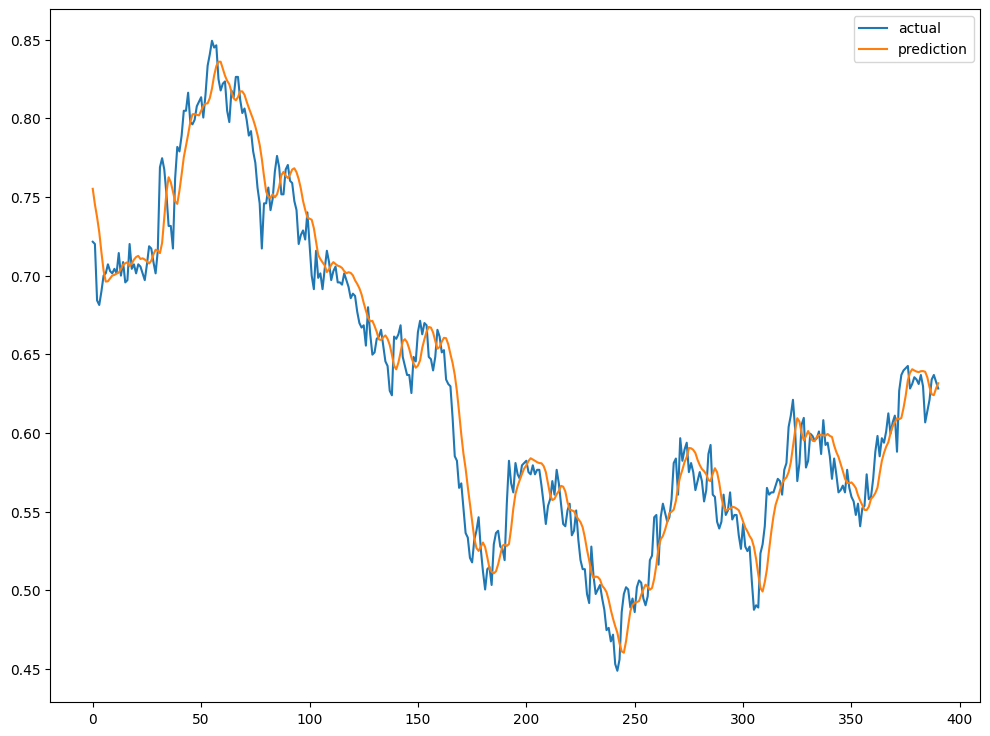

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()